In [34]:
# Допоміжні функції
def find_zero(state):
    for i, row in enumerate(state):
        for j, val in enumerate(row):
            if val == 0:
                return i, j

def copy_state(state):
    return [row[:] for row in state]

def h1(state):
    goal_state = [
        [1, 2, 3],
        [4, 5, 6],
        [7, 8, 0]
    ]
    count = 0
    for i in range(3):
        for j in range(3):
            if state[i][j] != 0 and state[i][j] != goal_state[i][j]:
                count += 1
    return count

def generate_neighbors(state):
    neighbors = []
    x, y = find_zero(state)
    moves = [(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1)]  # Up, Down, Left, Right

    for move in moves:
        if 0 <= move[0] < 3 and 0 <= move[1] < 3:
            new_state = copy_state(state)
            new_state[x][y], new_state[move[0]][move[1]] = new_state[move[0]][move[1]], new_state[x][y]
            neighbors.append(new_state)

    return neighbors

Steps: 2, Successes: 11
Steps: 3, Successes: 11
Steps: 4, Successes: 23
Steps: 5, Successes: 20
Steps: 6, Successes: 34
Steps: 7, Successes: 41
Steps: 8, Successes: 42
Steps: 9, Successes: 47
Steps: 10, Successes: 56
Steps: 11, Successes: 54
Steps: 12, Successes: 57
Steps: 13, Successes: 59
Steps: 14, Successes: 60
Steps: 15, Successes: 60
Steps: 16, Successes: 60
Steps: 17, Successes: 60
Steps: 18, Successes: 60
Steps: 19, Successes: 60
Steps: 20, Successes: 60


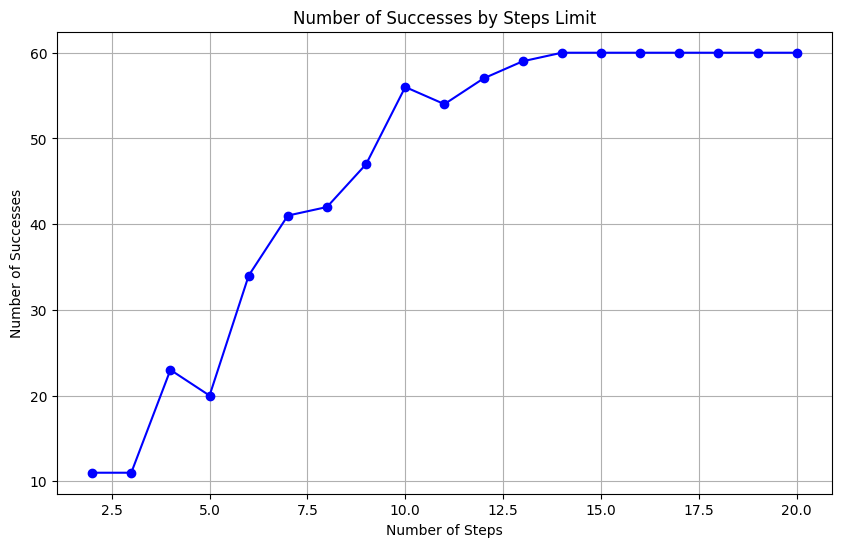

In [38]:
import random
import time

# Алгоритм LDFS
def LDFS(state, goal, depth, limit, nodes_generated, max_nodes_in_memory, path=[]):
    nodes_generated[0] += 1
    max_nodes_in_memory[0] = max(max_nodes_in_memory[0], len(path))
    
    if state == goal:
        return path + [state]

    if depth == limit:
        return None

    for neighbor in generate_neighbors(state):
        if neighbor not in path:  # Avoid cycles
            result = LDFS(neighbor, goal, depth + 1, limit, nodes_generated, max_nodes_in_memory, path + [state])
            if result is not None:
                return result

    return None

# Функція для перемішування початкового стану
def shuffle_state(state, moves=100):
    for _ in range(moves):
        neighbors = generate_neighbors(state)
        state = random.choice(neighbors)
    return state

# Функція для виконання експерименту
def run_experiment(initial_state, goal_state, limit):
    start_time = time.time()
    nodes_generated = [0]
    max_nodes_in_memory = [0]
    result = LDFS(initial_state, goal_state, 0, limit, nodes_generated, max_nodes_in_memory)
    end_time = time.time()
    
    return {
        "initial_state": initial_state,
        "time": end_time - start_time,
        "nodes_generated": nodes_generated[0],
        "max_nodes_in_memory": max_nodes_in_memory[0],
        "result": "Success" if result else "Failure"
    }

# Виконання серії експериментів
import matplotlib.pyplot as plt

# запуск всякого
goal_state = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 0]
]

def run_experiments(goal_state, num_experiments):
    steps_range = range(2, 21, 1)  # Від 2 до 20 з кроком 2
    successes_by_steps = []

    for steps_limit in steps_range:
        successes = 0
        for experiment in range(num_experiments):
            initial_state = shuffle_state(goal_state, moves=20)
            experiment_result = run_experiment(initial_state, goal_state, steps_limit)
            
            if experiment_result['result'] == 'Success':
                successes += 1

        successes_by_steps.append(successes)
        print(f"Steps: {steps_limit}, Successes: {successes}")

    # Візуалізація результатів
    plt.figure(figsize=(10, 6))
    plt.plot(steps_range, successes_by_steps, marker='o', linestyle='-', color='blue')
    plt.xlabel('Number of Steps')
    plt.ylabel('Number of Successes')
    plt.title('Number of Successes by Steps Limit')
    plt.grid(True)
    plt.show()

run_experiments(goal_state, 60)
